**Written and Directed by:** Ιωάννης Φακίνος, 03116158

# **Συστήματα και Τεχνολογίες Γνώσης**
# **Θέμα 2**
Σε αυτό το θέμα θα κατασκευάσετε μια οντολογία η οποία θα περιγράφει το πεδίο των ταινιών, και θα είναι συμβατή με το γράφο γνώσης που κατασκευάσατε στο πρώτο θέμα.

## 1ο Μέρος: Συντακτικά Ορθή Οντολογία


Σε αυτό το μέρος θα μετατρέψετε το γράφο γνώσης που δημιουργήσατε στο πρώτο θέμα, σε συντακτικά ορθή οντολογία. Όποιος επιθυμεί (κυρίως για άτομα που δεν έχουν ολοκληρώσει το πρώτο θέμα) μπορεί να εργαστεί με το γράφο γνώσης που σας δίνεται στο αρχείο ```movies.nt```.
<!-- Όποιος χρησιμοποιήσει τη δική του γνώση (που δημιούργησε στο πρώτο θέμα) κι **ΌΧΙ** το movies.nt θα έχει bonus της τάξεως του 20%.  -->

Θα εργαστούμε με τη βιβλιοθήκη [owlready2](https://owlready2.readthedocs.io/en/latest/) η οποία δίνει πρόσβαση σε τεχνολογίες αναπαράστασης γνώσης και οντολογιών (π.χ. OWL) μέσω της Python.


In [1]:
!pip install owlready2

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### 1.1 Αντιμετώπιση των parsing errors
Η owlready2 κάνει κάποιους ελέγχους κατά το parsing ενός αρχείου, για παράδειγμα αν κάτι είναι δηλωμένο ως ακέραιος σε έναν κόμβο της μορφής
```
"186.0"^^<http://www.w3.org/2001/XMLSchema#int>
```
Η owlready2 ελέγχει (μέσω των τύπων της python) αν αυτό είναι όντως ακέραιος. Στη συγκεκριμένη περίπτωση θα προκύψει σφάλμα
```
ValueError: invalid literal for int() with base 10: '186.0'
``` 
Επομένως το πρώτο ζητούμενο είναι να τροποποιήσετε κατάλληλα το γράφο γνώσης σας ώστε να τρέξει χωρίς σφάλμα η εντολή:
```python
onto = get_ontology('file://path/to/knowledge/graph').load()
```

**Σχόλια:**

Οι αλλαγές όπου επιβάλλει το ακόλουθο κομμάτι κώδικα είναι οι ακόλουθες:
* Μετατροπή των *literals* τύπου ```xsd:int``` σε format με μηδενικά δεκαδικά στοιχεία.
* Αφαίρεση του προθέματος νομίσματος από τα *literals* σχεατικά με χρηματικά ποσά και μετατροπή των αντίστοιχων τιμών σε US dollars.
* Αφαίρεση των τριάδων σχετικών με ημερομηνία ```<http://example.org/props/date>```, καθώς η ίδια πληροφορία αποθηκεύεται και σε τριάδες με το predicate ```<http://example.org/props/year>```.

In [4]:
from owlready2 import *
import re
import shlex

xmlint = "<http://www.w3.org/2001/XMLSchema#integer>"
xmldate = "<http://www.w3.org/2001/XMLSchema#date>"
currency_regex = '(\$|DEM|EUR|FRF|HKD|JPY|GBP|INR|SEK|AUD|KRW|NLG|CAD|RUR) '

def currency_to_us_dollars(num_str):
    currency, value = num_str.split()
    d = {
        "$": 1.0,
        "DEM": 0.620336,
        "EUR": 1.21,
        "FRF": 0.185009,
        "HKD": 0.13,
        "JPY": 0.0091,
        "GBP": 1.41,
        "INR": 0.014,
        "SEK": 0.12,
        "AUD": 0.77,
        "KRW": 0.00088,
        "NLG": 0.55,
        "CAD": 0.83,
        "RUR": 0.013,
    }
    return round(d[currency]*float(value))

if not os.path.exists("new_graph.nt"):
    raise FileNotFoundError("Please ensure that new_graph.nt file is uploaded inside the runtime.")

with open("./owl_graph.nt","wt") as fout, open("./new_graph.nt","rt") as fin:
    altered, ignored = 0, 0
    for line in fin:
        if line != "\n":
            if re.search(xmlint, line) != None:
                altered += 1
                sub, pred, obj = shlex.split(line)[:3]
                num_str = obj.split("^^")[0]
                if re.search(currency_regex, num_str) != None:
                    num = currency_to_us_dollars(num_str)
                else:
                    num = int(float(num_str))
                fout.write(f'{sub} {pred} "{num}"^^{xmlint} .\n')
            elif re.search(xmldate, line) != None:
                ignored += 1
                continue
            else:
                fout.write(line)

print(f'{altered} lines were altered & {ignored} lines were ignored.')

onto_simple = get_ontology('./owl_graph.nt').load()
print("Ontology created successfully!")

4004 lines were altered & 528 lines were ignored.
Ontology created successfully!


### 1.2 Μετατροπή σε owl
Αφού διορθώσαμε τα λάθη, πλέον το αρχείο μας μπορεί να φορτωθεί μέσω της βιβλιοθήκης owlready2. Αν και η μορφή (format) του αρχείου είναι συμβατή με το πρότυπο OWL **δεν είναι μια σημασιολογικά ορθή οντολογία**, είναι απλά ένα σύνολο από δεδομένα σε μια μορφή που είναι συμβατή με το πρότυπο OWL. Μια οντολογία ορίζει ένα σύνολο από κανόνες που διέπουν έναν κόσμο, **δεν** είναι απλά μια αναπαράσταση των δεδομένων όπως είναι ένας γράφος γνώσης (αν και τα περισσότερα αξιώματα της οντολογίας μπορούν να αναπαρασταθούν με γράφους γνώσης).

Τα βασικά συστατικά μέρη μιας οντολογίας είναι οι ατομικές έννοιες -τις οποίες συναντάμε στην OWL ως κλάσεις-(concepts-CN), οι ατομικοί ρόλοι -τους οποίους συναντάμε στην OWL ως ιδιότητες αντικειμένου και ιδιότητες τύπου δεδομένων- (roles-RN) και τα άτομα (individuals-IN). Με βάση αυτά κατασκευάζονται εκφράσεις σύνθετων εννοιών  και ρόλων, και αξιώματα (axioms).

Στην παρούσα φάση δεν έχουμε αξιώματα και τόσο το σύνολο CN όσο και το RN είναι κενά. Πρακτικά έχουμε μόνο πληροφορία που αφορά τους individuals (τα άτομα του κόσμου μας) η οποία προέρχεται από το γράφο γνώσης μας. Δεν έχουμε λοιπόν καμία πληροφορία για τους κανόνες που διέπουν τον κόσμο, τις έννοιες από τις οποίες αποτελείται ο κόσμος μας όπως και τις πιθανές σχέσεις μεταξύ αυτών των εννοιών. Αυτή την πληροφορία καλείστε να συμπληρώσετε στη συνέχεια της άσκησης.

Στην οντολογία μας λοιπόν θα πρέπει να ορίσουμε αρχικά έννοιες:
```xml
#RDF/XML
<owl:Class rdf:about="http://example.org/ns/Concept"/>

#N-triples
<http://example.org/ns/Concept> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://www.w3.org/2002/07/owl#Class> 
```
καθώς και ρόλους:
```xml
#RDF/XML
<owl:ObjectProperty rdf:about="http://example.org/props/role"/>

#N-triples
<http://example.org/props/role> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://www.w3.org/2002/07/owl#ObjectProperty> 
```



#### 1.2.1 Αρχικοποίηση του CN

Σε πρώτη φάση πρέπει να ορίσετε τις απαραίτητες έννοιες για να αναπαρασταθούν σωστά τα δεδομένα σας, δηλαδή κάθε άτομο του κόσμου σας να έχει έναν τύπο ο οποίος θα είναι κάποια έννοια. Για παράδειγμα στα δεδομένα σας έχετε σίγουρα ταινίες και σκηνοθέτες. Για να αναπαρασταθούν σωστά αυτά τα άτομα είναι απαραίτητες οι έννοιες "Movie" και "Director" αντίστοιχα. Φυσικά μπορείτε να δώσετε ό,τι ονόματα επιθυμείτε εσείς στις έννοιες, όμως θα συνιστούσαμε να κρατήσετε το ίδιο μοτίβο σε όλη την άσκηση, και να δώσετε χαρακτηριστικά αλλά και συνοπτικά ονόματα τόσο στις έννοιες όσο και στους ρόλους. Για αρχή θα ορίσουμε όλες τις έννοιες να είναι υποέννοιες (subClassOf) του Thing, και σε επόμενο ερώτημα θα προχωρήσουμε στη δημιουργία πιο σύνθετων ιεραρχιών. 

Πρώτα όμως πρέπει να αρχικοποιήσουμε μια οντολογία φορτώνοντας το γράφο γνώσης στο owlready2 με την εντολή
```python
onto=get_ontology('file://path/to/knowledge/graph').load()
```
Θα ορίσουμε τους ονοματοχώρους που χρησιμοποιεί, στη συγκεκριμένη περίπτωση  "prop" για τους ρόλους (που αντιστοιχούν στις ιδιότητες του γράφου- properties) και "ns" για τις έννοιες.
```python
prop = onto.get_namespace('http://example.org/props/')
ns = onto.get_namespace('http://example.org/ns/')
```

Ο ορισμός των εννοιών Movie και Director κάτω από το Thing, χρησιμοποιώντας τον ονοματοχώρο ```http://example.org/ns/``` στην owlready2 γίνεται ως εξής:
```python
with onto:
  with ns:
    class Movie(Thing):
      pass
    class Director(Thing):
      pass
```

Αν τώρα αποθηκεύσουμε την οντολογία, θα παρατηρήσουμε πως έχουν προστεθεί τριάδες της μορφής
```xml
#RDF/XML
<owl:Class rdf:about="http://example.org/ns/Director">
  <rdfs:subClassOf rdf:resource="http://www.w3.org/2002/07/owl#Thing"/>
</owl:Class>

#N-triples
<http://myontology.org#Director> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://www.w3.org/2002/07/owl#Class> .
<http://myontology.org#Director> <http://www.w3.org/2000/01/rdf-schema#subClassOf> <http://www.w3.org/2002/07/owl#Thing> .
```
Δηλαδή έχει οριστεί η έννοια Director ως owl:Class η οποία είναι υποέννοια (rdfs:subClassOf) του owl:Thing.

Με τον ίδιο τρόπο καλείστε να αρχικοποιήσετε το σύνολο ονομάτων εννοιών - CN.


*Σημείωση: δεν είναι απαραίτητο να ορίσετε ρητά ποιοι individual είναι τύπου Movie, DIrector, κλπ. μιας και αυτό μπορεί να το συμπεράνει ο reasoner (θα δούμε τι είναι αυτό στο μάθημα και στο επόμενο θέμα) εάν ορίσετε τα κατάλληλα πεδία τιμών και πεδία ορισμού που θα δείτε στο δεύτερο (2ο) μέρος.* 

Μπορείτε να "σώσετε" μια οντολογία με την owlready2 όπως φαίνεται παρακάτω, σε μορφή RDF/XML και N-triples αντίστοιχα. Η μορφή RDF/XML είναι η default επιλογή.

```python
with onto:
  #RDF/XML
  onto.save('myOnto.owl',format='rdfxml')
  # or just: onto.save('myOnto.owl')

  #N-triples
  onto.save('myOnto.nt',format='ntriples')

```

In [5]:
from owlready2 import *

prop = onto_simple.get_namespace('http://example.org/props/')
ns = onto_simple.get_namespace('http://example.org/ns/')

with onto_simple:
    with ns:
        class Movie(Thing):
            pass
        class Genre(Thing):
            pass
        class Actor(Thing):
            pass
        class Director(Thing):
            pass
        class Writer(Thing):
            pass
        class Country(Thing):
            pass
        class Company(Thing):
            pass
        class Language(Thing):
            pass
with onto_simple:
    onto_simple.save('./my_onto.owl')
    onto_simple.save('./my_onto.nt',format='ntriples')

#### 1.2.2 Αρχικοποίηση του RN

Σειρά έχει η αρχικοποίηση του RN. Πρακτικά θέλουμε να δημιουργήσετε έναν ρόλο για κάθε ιδιότητα (property) του γράφου γνώσης σας. Αυτό μπορείτε να το επιτύχετε ορίζοντας πως κάθε ακμή του γράφου γνώσης είναι ένα ```owl:ObjectProperty``` αν συνδέει individuals μεταξύ τους ή ένα ```owl:DataProperty``` αν συνδέει individuals με τύπους δεδομένων.  

Προσοχή: οι ρόλοι **ΔΕΝ** συνδέουν individuals με έννοιες, αυτό γίνεται μέσω της σχέσης rdfs:type. Θα πρέπει λοιπόν να έχετε κατά νου πως δεν πρέπει να δημιουργήσετε ρόλους που συνδέουν individuals με έννοιες, το οποίο είναι πολύ πιθανό να συμβεί σε περίπτωση που στο γράφο γνώσης σας έχετε κάποια σχέση της μορφής "is_a". 

Για να ορίσουμε τους απαραίτητους ρόλους, πρώτα βρίσκουμε το σύνολο ονομάτων ακμών στο γράφο γνώσης, δηλαδή το σύνολο των URIs τα οποία εμφανίζονται στη μεσαία θέση μιας τριάδας. Έστω πως το σύνολο αυτό περιέχει τα εξής URIs:
```
<http://example.org/props/hasActor>
<http://example.org/props/hasTitle>
```

Θέλουμε να ορίσουμε λοιπόν πως το URI ```<http://example.org/props/hasActor>``` είναι owl:ObjectProperty ενώ το ```<http://example.org/props/hasTitle>``` είναι owl:DataProperty. Στην owlready2 αυτό γίνεται ως εξής:
```python
with onto:
  with prop:
    class hasActor(ObjectProperty):
      pass
    class hasTitle(DataProperty):
      pass
```

Αν τώρα αποθηκεύσουμε την οντολογία σε ένα αρχείο
```python
with onto:
  #RDF/XML
  onto.save('myonto.owl')

  #N-triples
  onto.save('myonto.nt',format='ntriples')
```
και ανοίξουμε το αρχείο θα δούμε να έχουν προστεθεί τα ακόλουθα:
```xml
#RDF/XML
<owl:ObjectProperty rdf:about="http://example.org/props/hasActor"/>
<owl:DatatypeProperty rdf:about="http://example.org/props/hasTitle"/>


#N-triples
<http://example.org/props/hasActor> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://www.w3.org/2002/07/owl#ObjectProperty> .
<http://example.org/props/hasTitle> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://www.w3.org/2002/07/owl#DatatypeProperty> .
```
Δηλαδή προσθέσαμε τα ονόματα δύο ρόλων στην οντολογία μας, η οποία αρχίζει να παίρνει μορφή. 

Με τον ίδιο τρόπο καλείστε να αρχικοποιήσετε την οντολογία σας και να ορίσετε το σύνολο ονομάτων ρόλων - RN.

*Προσοχή: σε αυτό το βήμα να χρησιμοποιήσετε για ονόματα ρόλων τα ίδια ακριβώς ονόματα που υπάρχουν στις ιδιότητες του γράφου γνώσης σας ώστε να μην χρειάζετε να κάνετε αλλαγές στη συνέχεια. Εάν ορίσετε διαφορετικό όνομα (π.χ. ορίσετε το ρόλο "actors" για την ιδιότητα "hasActors" που υπάρχει στο γράφο γνώσης) τότε θα πρέπει στη συνέχεια να αλλάξετε την πληροφορία που έχετε για όλα τα άτομα του κόσμου σας, ενώ εάν χρησιμοποιήσετε το ίδιο όνομα (και ίδιο ονοματόχωρο όπως έχουμε ορίσει παραπάνω) αυτό δεν θα χρειαστεί διότι θα είναι συμβατή η ονομασία με την ήδη υπάρχουσα πληροφορία (π.χ. η "τριάδα RDF" ```<http://example.org/ns/Django_Unchained> <http://example.org/props/hasActor> <http://example.org/ns/Leonardo_DiCaprio>``` που μπορεί να υπάρχει ήδη στην οντολογία μας από το γράφο γνώσης θα δείχνει τη σύνδεση με το ρόλο "hasActor" μεταξύ του Django Unchained και του Leonardo DiCaprio ενώ εάν ο αντίστοιχος ρόλος έχει ονομαστεί διαφορετικά τότε αυτή η τριάδα δεν θα αντιστοιχεί σε κανένα ρόλο της οντολογίας μας και θα πρέπει να την αλλάξουμε).*

In [6]:
with onto_simple:
    with prop:
        class actor(ObjectProperty):
            domain = [Movie]
            range = [Actor]
            pass
        class writer(ObjectProperty):
            domain = [Movie]
            range = [Writer]
            pass
        class director(ObjectProperty):
            domain = [Movie]
            range = [Director]
            pass
        class company(ObjectProperty):
            domain = [Movie]
            range = [Company]
            pass
        class language(ObjectProperty):
            domain = [Movie]
            range = [Language]
            pass
        class country(ObjectProperty):
            domain = [Movie]
            range = [Country]
            pass
        class genre(ObjectProperty):
            domain = [Movie]
            range = [Genre]
            pass
        class title(DataProperty):
            domain = [Movie]
            range = [str]
            pass
        class duration(DataProperty):
            domain = [Movie]
            range = [int]
            pass
        class year(DataProperty):
            domain = [Movie]
            range = [int]
            pass
        class budget(DataProperty):
            domain = [Movie]
            range = [int]
            pass
        class descrition(DataProperty):
            domain = [Movie]
            range = [str]
            pass
        class votes(DataProperty):
            domain = [Movie]
            range = [int]
            pass
        class metascore(DataProperty):
            domain = [Movie]
            range = [int]
            pass
        class worldwide_gross_income(DataProperty):
            domain = [Movie]
            range = [int]
            pass
        class usa_gross_income(DataProperty):
            domain = [Movie]
            range = [int]
            pass
        class reviews_from_users(DataProperty):
            domain = [Movie]
            range = [int]
            pass
        class reviews_from_critics(DataProperty):
            domain = [Movie]
            range = [int]
            pass

with onto_simple:        
    onto_simple.save('my_onto.owl')
    onto_simple.save('my_onto.nt',format='ntriples')  

### 1.2.3 Σημασιολογικά Ορθή Οντολογία

Πλέον έχουμε μετατρέψει το γράφο γνώσης μας σε μια συντακτικά ορθή οντολογία. Αυτό δεν σημαίνει όμως πως είναι και σημασιολογικά ορθή και συνεπής.

Αυτή τη στιγμή έχετε αντιστοιχίσει συντακτικά το γράφο γνώσης του πρώτου θέματος σε μια οντολογία. Προσθέσατε τις κατάλληλες έννοιες (π.χ. Movie, Actor, κλπ) και αντιστοιχίσατε τις ιδιότητες (properties) στους κατάλληλους ρόλους. Όμως η μοντελοποίηση αυτής της οντολογίας μπορεί να μην είναι σωστή ή/και συνεπής, διότι η οντολογία, όπως έχουμε αναφέρει και παραπάνω, δεν είναι απλώς ένας διαφορετικός τρόπος να αναπαραστήσει κανείς ένα γράφο γνώσης. Μία οντολογία μοντελοποιεί έναν κόσμο (όπου συνήθως βασίζεται στον πραγματικό κόσμο), διέπεται από σαφείς κανόνες, και απαιτεί ορισμένες σχεδιαστικές επιλογές από το δημιουργό της. 

Σε αυτό το ζητούμενο καλείστε να μελετήσετε την οντολογία που έχετε δημιουργήσει μέχρι στιγμής και να αναθεωρήσετε/αλλάξετε ορισμένα κομμάτια της μοντελοποίησης ώστε να είναι πιο ορθή / να ανταποκρίνεται καλύτερα στην πραγματικότητα.  
Για παράδειγμα πιθανότατα στην οντολογία που έχετε δημιουργήσει, μια ταινία (ένας individual που έχει type Movie) συνδέεται με έναν ρόλο της μορφής hasGenre με έναν άλλο individual που είναι τύπου Genre και αντιστοιχεί στην κωμωδία (ή οποιοδήποτε άλλο genre). Αυτή, αν και τυπικά δεν είναι λαθος μοντελοποιηση, δεν μπορεί να θεωρηθεί ούτε απόλυτα σωστή, μιας και η κωμωδία δεν είναι άτομο του κόσμου μας, είναι μια έννοια/ένας όρος με τον οποίο χαρακτηρίζονται έργα με ορισμένα (ίσως κι αφηρημένα) χαρακτηριστικά. 

Θα μπορούσε κάποιος να σκεφτεί να ορίσει την έννοια Genre, και όλα τα είδη ως υποέννοιες της Genre. Στη συνέχεια να προσθέσει την πληροφορία πως κάθε ταινία (individual με type Movie) είναι και τύπου Κωμωδίας (Comedy) το οποίο θα είναι υποέννοια του Genre όπως αναφέραμε. Αυτή η μοντελοποίηση είναι όμως **ΛΑΘΟΣ**, αφού αν οριστεί π.χ. ο Άρχοντας των Δαχτυλιδιών ως άτομο τύπου Fantasy, τότε αφού το Fantasy είναι υποέννοια του Genre, προκύπτει σημασιολογικά πως ο Άρχοντας των Δακτυλιδιών είναι άτομο τύπου Genre, το οποίο είναι λάθος.

Άρα στην περίπτωσή μας όπου δημιουργούμε μια οντολογία για ταινίες πιο ορθή φαντάζει μια μοντελοποίηση της πληροφορίας πως κάποια ταινία είναι κωμωδία ως μίας έννοιας ComedyMovie (ή και απλά Comedy) όπου είναι υποέννοια (subClassOf) της έννοιας Movie. 

Καλείστε λοιπόν να εντοπίσετε και να διορθώσετε αντίστοιχα λάθη μοντελοποίησης της οντολογίας σας. Αφαιρέστε τη "λανθασμένη" πληροφορία και αντικαταστήστε τη με την "ορθή". Στο παραπάνω παράδειγμα με την κωμωδία μια τέτοια αντικατάσταση θα μπορούσε να γίνει δημιουργώντας τις κατάλληλες έννοιες (ComedyMovie, DramaMovie, κλπ), ορίζοντας το κατάλληλο type στους αντίστοιχους individuals και αφαιρώντας τους ρόλους hasGenre καθώς και όλους τους individuals που αντιστοιχούσαν σε κάποιο Genre.
Αναφέρετε συνοπτικά τις αλλαγές που κάνατε και σχολιάστε τις. 

<!-- Παρακάτω δίνεται ενδεικτικό κομμάτι κώδικα για να επιτελέσετε τα παραπάνω.  -->

Στο τέλος αυτού του μέρους αποθηκεύστε την οντολογία σας σε ένα αρχείο KR-Ex2_1.owl όπως δείξαμε παραπάνω, το οποίο θα παραδοθεί μαζί με τα υπόλοιπα αρχεία στο τέλος της άσκησης. 

In [5]:
!pip install rdflib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [6]:
# Find all genres that are stores inside new_graph.nt file
from rdflib import Graph, Literal, URIRef, Namespace
from rdflib.namespace import XSD

g = Graph()
g.parse('owl_graph.nt',format='nt')

ans = g.query(
    """
        prefix exp: <http://example.org/props/>
        prefix ex: <http://example.org/ns/>
      
        select distinct ?genre
        where {
            ?movie exp:genre ?genre .
        }
        order by ?genre
    """)
print(f"Available {len(ans)} movie genres:")
for genre in ans:
    print(str(genre[0]).split("/")[-1])

Available 20 movie genres:
Action
Adventure
Animation
Biography
Comedy
Crime
Drama
Family
Fantasy
History
Horror
Music
Musical
Mystery
Romance
Sci-Fi
Sport
Thriller
War
Western


In [3]:
"""
Need to remove triples with genre property
Genre individuals have NO meaning no more,
as each movie will be create as a new instance
of one movie type.
"""

prop_actor = "<http://example.org/props/actor>"
prop_hasActor = "<http://example.org/props/hasActor>"
prop_writer = "<http://example.org/props/writer>"
prop_hasWriter = "<http://example.org/props/hasWriter>"
prop_company = "<http://example.org/props/company>"
prop_hasCompany = "<http://example.org/props/hasCompany>"
prop_director = "<http://example.org/props/director>"
prop_hasDirector = "<http://example.org/props/hasDirector>"
prop_genre = "<http://example.org/props/genre>"
rdf_type = "<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>"
prop_country = "<http://example.org/props/country>"
prop_inCountry = "<http://example.org/props/inCountry>"
prop_language = "<http://example.org/props/language>"
prop_inLanguage = "<http://example.org/props/inLanguage>"
prop_title = "http://example.org/props/title"
prop_hasTitle = "http://example.org/props/hasTitle"
prop_avg_vote = "http://example.org/props/avg_vote"
prop_hasAvgVote = "http://example.org/props/hasAvgVote"
prop_budget = "http://example.org/props/budget"
prop_hasBudget = "http://example.org/props/hasBudget"
prop_description = "http://example.org/props/description"
prop_hasDescription = "http://example.org/props/hasDescription"
prop_duration = "http://example.org/props/duration"
prop_hasDuration = "http://example.org/props/hasDuration"
prop_metascore = "http://example.org/props/metascore"
prop_hasMetascore = "http://example.org/props/hasMetascore"
prop_reviews_from_critics = "http://example.org/props/reviews_from_critics"
prop_hasReviewsFromCritics = "http://example.org/props/hasReviewsFromCritics"
prop_reviews_from_users = "http://example.org/props/reviews_from_users"
prop_hasReviewsFromUsers = "http://example.org/props/hasReviewsFromUsers"
prop_usa_gross_income = "http://example.org/props/usa_gross_income"
prop_hasUSAGrossIncome = "http://example.org/props/hasUSAGrossIncome"
prop_votes = "http://example.org/props/votes"
prop_hasVotes = "http://example.org/props/hasVotes"
prop_worldwide_gross_income = "http://example.org/props/worldwide_gross_income"
prop_hasWorldwideGrossIncome = "http://example.org/props/hasWorldwideGrossIncome"
prop_year = "http://example.org/props/year"
prop_releasedInYear = "http://example.org/props/releasedInYear"

def reform_genre(line):
    sub, _, obj, _ = line.split()
    return f"{sub} {rdf_type} <{obj[1:-1].replace('-','')}Movie> .\n"

with open("owl_graph.nt","rt") as fin, open("owl_graph_modified.nt","wt") as fout:
    ignored, altered = 0, 0
    for line in fin:
        if re.search(prop_genre, line) != None:
            altered += 1
            fout.write(reform_genre(line))
        elif re.search(prop_avg_vote, line) != None:
            ignored += 1
            continue
        elif re.search(prop_actor, line) != None:
            altered += 1
            fout.write(re.sub(prop_actor,prop_hasActor,line))
        elif re.search(prop_director, line) != None:
            altered += 1
            fout.write(re.sub(prop_director,prop_hasDirector,line))
        elif re.search(prop_writer, line) != None:
            altered += 1
            fout.write(re.sub(prop_writer,prop_hasWriter,line))
        elif re.search(prop_company, line) != None:
            altered += 1
            fout.write(re.sub(prop_company,prop_hasCompany,line))
        elif re.search(prop_country, line) != None:
            altered += 1
            fout.write(re.sub(prop_country,prop_inCountry,line))
        elif re.search(prop_language, line) != None:
            altered += 1
            fout.write(re.sub(prop_language,prop_inLanguage,line))
        elif re.search(prop_title, line) != None:
            altered += 1
            fout.write(re.sub(prop_title,prop_hasTitle,line))
        elif re.search(prop_budget, line) != None:
            altered += 1
            fout.write(re.sub(prop_budget,prop_hasBudget,line))
        elif re.search(prop_description, line) != None:
            altered += 1
            fout.write(re.sub(prop_description,prop_hasDescription,line))
        elif re.search(prop_duration, line) != None:
            altered += 1
            fout.write(re.sub(prop_duration,prop_hasDuration,line))
        elif re.search(prop_metascore, line) != None:
            altered += 1
            fout.write(re.sub(prop_metascore,prop_hasMetascore,line))
        elif re.search(prop_reviews_from_critics, line) != None:
            altered += 1
            fout.write(re.sub(prop_reviews_from_critics,prop_hasReviewsFromCritics,line))
        elif re.search(prop_reviews_from_users, line) != None:
            altered += 1
            fout.write(re.sub(prop_reviews_from_users,prop_hasReviewsFromUsers,line))
        elif re.search(prop_usa_gross_income, line) != None:
            altered += 1
            fout.write(re.sub(prop_usa_gross_income,prop_hasUSAGrossIncome,line))
        elif re.search(prop_votes, line) != None:
            altered += 1
            fout.write(re.sub(prop_votes,prop_hasVotes,line))
        elif re.search(prop_worldwide_gross_income, line) != None:
            altered += 1
            fout.write(re.sub(prop_worldwide_gross_income,prop_hasWorldwideGrossIncome,line))
        elif re.search(prop_year, line) != None:
            altered += 1
            fout.write(re.sub(prop_year,prop_releasedInYear,line))
#         else:
#             fout.write(line)
print(f"{altered} lines were altered & {ignored} lines were ignored")
print("New file owl_graph_no_genres.nt created")

18149 lines were altered & 528 lines were ignored
New file owl_graph_no_genres.nt created


In [2]:
del onto_simple
onto = get_ontology('./owl_graph_modified.nt').load()
prop = onto.get_namespace('http://example.org/props/')
ns = onto.get_namespace('http://example.org/ns/')

with onto:
    with ns:
        class Movie(Thing):
            pass
        class ActionMovie(Movie):
            pass
        class AdventureMovie(Movie):
            pass
        class AnimationMovie(Movie):
            pass
        class BiographyMovie(Movie):
            pass
        class ComedyMovie(Movie):
            pass
        class CrimeMovie(Movie):
            pass
        class DramaMovie(Movie):
            pass
        class FamilyMovie(Movie):
            pass
        class FantasyMovie(Movie):
            pass
        class HistoryMovie(Movie):
            pass
        class HorrorMovie(Movie):
            pass
        class MusicMovie(Movie):
            pass
        class MusicalMovie(Movie):
            pass
        class MysteryMovie(Movie):
            pass
        class RomanceMovie(Movie):
            pass
        class SciFiMovie(Movie):
            pass
        class SportMovie(Movie):
            pass
        class ThrillerMovie(Movie):
            pass
        class WarMovie(Movie):
            pass   
        class WesternMovie(Movie):
            pass
        class Actor(Thing):
            pass
        class Writer(Thing):
            pass
        class Director(Thing):
            pass
        class Company(Thing):
            pass
        class Country(Thing):
            pass
        class Language(Thing):
            pass
        
with onto:
    onto.save('KR_Ex2_1.owl')
    onto.save('KR_Ex2_1.nt',format='ntriples')

In [3]:
with onto:
    with prop:
        class hasTitle(Movie >> str):
            pass
        class hasBudget(Movie >> int):
            pass
        class hasDescription(Movie >> str):
            pass
        class hasDuration(Movie >> int):
            pass
        class hasMetascore(Movie >> int):
            pass
        class hasReviewsFromCritics(Movie >> int):
            pass
        class hasReviewsFromUsers(Movie >> int):
            pass
        class hasUSAGrossIncome(Movie >> int):
            pass
        class hasVotes(Movie >> int):
            pass
        class hasWorldwideGrossIncome(Movie >> int):
            pass
        class releasedInYear(Movie >> int):
            pass
        class hasActor(ObjectProperty):
            domain = [Movie]
            range = [Actor]
            pass
        class hasWriter(ObjectProperty):
            domain = [Movie]
            range = [Writer]
            pass
        class hasDirector(ObjectProperty):
            domain = [Movie]
            range = [Director]
            pass
        class hasCompany(ObjectProperty):
            domain = [Movie]
            range = [Company]
            pass
        class inLanguage(ObjectProperty):
            domain = [Movie]
            range = [Language]
            pass
        class inCountry(ObjectProperty):
            domain = [Movie]
            range = [Country]
            pass
with onto:
    onto.save('KR_Ex2_1.owl')
    onto.save('KR_Ex2_1.nt',format='ntriples')

**Παρατηρήσεις**

Ακολουθήθηκε η λογική που προτείνεται από την εκφώνηση. Συγκεκριμένα, για κάθε τύπο ταινίας (συνολικά 20) εισήχθει ξεχωριστή κλάση υποκλάση της κλάσης *Movie*. Ιδιαίτερη προσοχή σε αυτήν την περίπτωση πρέπει να δωθεί στα uri, όπως το ακόλουθο <http://example.org/ns/Drama>, καθώς η ύπαρξή τους συνεπάγεται την ύπαρξη ξεχωριστών individuals. Επομένως, όλες οι τριάδες με το *property* 
<http://example.org/props/genre> αφαιρούνται από τον γράφο γνώσης, ο οποίος πλέον αποθηκεύεται στο αρχείο owl_graph_no_genres.nt, το οποίο στη συνέχεια αξιοποιείται για την παραγωγή της οντολογίας. Επίσης, η κλάση *genre*, υπό το namespace <http://example.org/props/> δεν έχει λόγο ύπαρξης.

## 2ο Μέρος: Σημασιολογικά Συνεπής Οντολογία και Εμπλουτισμός

 Στο δεύτερο (2ο) μέρος της άσκησης θα εργαστείτε στο [Protégé](https://protege.stanford.edu/). Θα εξαγάγετε την οντολογία που έχετε δημιουργήσει μέχρι στιγμής (μόνο τα CN και RN, όχι τους individuals) σε ένα αρχείο το οποίο θα επεξεργαστείτε με τη βοήθεια του Protégé για να εργαστείτε με τα επόμενα ζητούμενα. Προσέξτε για τη συνέχεια να μη σβήσετε καμία πληροφορία από την οντολογία (μόνο να προσθεσετε) διότι τότε μπορεί να σταματήσει να είναι συνεπής με τα δεδομένα που έχουμε, θεωρητικά δεν θα χρειαστεί να σβήσετε τίποτα διότι έχετε κάνει τις όποιες διορθώσεις έχουν χρειαστεί στα προηγούμενα ερωτήματα. 


Πριν φορτώσουμε την οντολογία στο [Protégé](https://protege.stanford.edu/), θα τρέξουμε τον reasoner μέσω του owlready2. Αυτό από τη μία θα μας δείξει αν η οντολογία που έχουμε φτιάξει ως τώρα είναι συνεπής, ενώ από την άλλη θα συμπεράνει ποια ονόματα αντιστοιχούν σε άτομα του κόσμου. Αυτά τα άτομα δεν μας αφορούν όταν θα δουλεύουμε την οντολογία στο protege οπότε θα τα σβήσουμε.

In [3]:
del onto
onto_new = get_ontology('./KR_Ex2_1.owl').load()

In [4]:
with onto_new:
    sync_reasoner()
    for i in onto_new.individuals():
        destroy_entity(i)

instances = onto_new.get_instances_of(Thing)
for i in instances:
    destroy_entity(i)
onto_new.save('my_onto_protege.owl')

* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /home/john/.local/lib/python3.6/site-packages/owlready2/hermit:/home/john/.local/lib/python3.6/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////tmp/tmpqsg5h6xj
* Owlready2 * HermiT took 5.91582465171814 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


### 2.1 Σημασιολογικά Συνεπής Οντολογία
Σε αυτό το ζητούμενο καλείστε να βάλετε περιορισμούς στον κόσμο σας ώστε να έχουμε μια οντολογία συνεπή με την πραγματικότητα. Πρέπει να δημιουργήσετε πεδία ορισμού (Π.Ο.) και πεδία τιμών (Π.Τ.) για τους ρόλους της οντολογίας σας, καθώς και να ορίσετε ξένες (disjoint) έννοιες και ρόλους (π.χ. δεν μπορεί ένας individual του κόσμου μας να είναι και ηθοποιός και ταινία ταυτόχρονα). 


Περιγράψτε τους περιορισμούς που ορίσατε στο markdown που ακολουθεί


### Απάντηση 2.1

### 2.2 Σημασιολογικός Εμπλουτισμός
Σε αυτό το ζητούμενο καλείστε να εμπλουτίσετε την οντολογία σας με νέες έννοιες, νέους ρόλους, και αξιώματα. Στόχος είναι να δημιουργήσετε μια οντολογία όσο πιο "πλήρη" μπορείτε. Οι έννοιες, οι ρόλοι, και τα αξιώματα που θα δημιουργήσετε **ΔΕΝ** είναι απαραίτητο να αφορούν πληροφορία η οποία είναι συνδεδεμένη με το σύνολο IN της οντολογίας σας, αυτή η σύνδεση μπορεί να γίνει κάποια στιγμή στο μέλλον μέσω κάποιοι εμπλουτισμού των δεδομένων σας, σε αυτή τη φάση σας ενδιαφέρει να δημιουργήσετε μία πολύ καλή περιγραφή του κόσμου σας. Αυτή η οντολογία που θα δημιουργήσετε θα μπορεί να "κουμπώσει" με δεδομένα από πολλές διαφορετικές πηγές (τα οποία βέβαια πρέπει να έχουν συμβατή μορφή και ονοματοδοσία), για αυτό και δεν περιοριζόμαστε μόνο στα δεδομένα που έχουμε αλλά σχεδιάζουμε τον "κόσμο" μας γενικότερα.

Ακολουθούν μερικά παραδείγματα / προτάσεις:

*   Μπορείτε να δημιουργήσετε έννοιες βασισμένες στη χώρα παραγωγής μιας ταινίας όπως EuropeanMovie ή KoreanMovie χωρίς να έχετε απαραίτητα την πληροφορία για ποιές συγκεκριμένες ταινίες της οντολογίας σας είναι Ευρωπαϊκές ή Κορεάτικες αντίστοιχα.

*   Εκμεταλευόμενοι τα DataTypes που πιθανώς υπάρχουν ήδη στην οντολογία σας μπορείτε να δημιουργήσετε έννοιες και αντίστοιχα αξιώματα ώστε να κατατάξετε τις ταινίες ως ταινίες υψηλού, μεσαίου και χαμηλού budget. 

*   Έχετε ακόμη τη δυνατότητα να δημιουργήσετε ιεραρχίες υψηλού επιπέδου μέσω αξιωμάτων, όπως για παράδειγμα πως η έννοια BlackComedyMovie είναι υπο-έννοια (subClassOf) της έννοιας ComedyMovie η οποία με τη σειρά της είναι υπο-έννοια του Movie.

*   Επίσης μπορείτε να δημιουργήσετε νέες "σύνθετες" έννοιες συνδυάζοντας ήδη υπάρχουσες όπως την έννοια ComedyActionMovie για ταινίες που είναι κωμωδίες και δράσης.   

*   Ένα ακόμη είδος εμπλουτισμού που μπορείτε να κάνετε είναι να δημιουργήσετε υπερ-ρόλους όπως για παράδειγμα ο ρόλος hasContributor μπορεί να είναι υπερ-ρόλος των ρόλων hasActor, hasDirector, και hasScreenWriter (και διαφόρων ακόμη). Αυτού του είδους ο εμπλουτισμός είναι όμοιος με την ιεαρχία που αναφέρεται παραπάνω. 

*   Μπορείτε να δημιουργήσετε ανάστροφους ρόλους, για παράδειγμα ο ρόλος isDirector ως ανάστροφος του hasDirector, ή το workedOn ως ανάστροφος ρόλος του hasContributor. 

*   Τέλος μπορείτε να συνδέσετε την οντολογία σας με κάποια άλλη οντολογία που υπάρχει διαθέσιμη στο διαδίκτυο (κι όχι μόνο) η οποία μπορεί είτε να έχει την ίδια θεματική με τη δική σας (δηλαδή ταινίες) είτε και να έχει κάποια άλλη θεματική αλλά να μπορεί να συνδεθεί με τη δική σας για να προσφέρει μια πιο λεπτομερή μοντελοποιηση του κόσμου σας. 


Η μοντελοποίησή σας πρέπει να στοχεύει και στη χρησιμότητα/χρηστικότητα της οντολογίας άρα θα πρέπει να δημιουργήσετε έννοιες, ρόλους, κι αξιώματα που μπορούν να φανούν χρήσιμα είτε σε έναν movie recommender, είτε σε μια streaming πλατφόρμα όπου δημιουργεί σύνθετες κατηγορίες (π.χ. Ευρωπαϊκός Κινηματογράφος της δεκαετίας του '90), είτε γενικότερα σε οποιαδήποτε άλλη χρήση μιας οντολογίας για ταινίες μπορείτε να σκεφτείτε. Μπορείτε να αντλήσετε έμπνευση από υπάρχουσες streaming πλατφόρμες (π.χ. Netflix, Cinobo, κ.α.). Θα συνιστούσαμε να δώσετε ιδιαίτερη προσοχή στο είδος (genre) καθώς και τη θεματική (subject) μιας ταινίας μιας και πρόκειται για δύο απο τα βασικότερα χαρακτηριστικά κατηγοριοποίησης ταινιών. 

Στο τέλος αυτού του ερωτήματος θα πρέπει να έχετε προσθέσει **τουλάχιστον 50 νέες έννοιες** συνολικά **σε τουλάχιστον 5 διαφορετικές "κατευθύνσεις" / domains** (π.χ. ένα domain θα μπορούσε να είναι τα genres, ένα άλλο να αφορά χρηματικά ποσά / budgets, ένα άλλο να αφορα τοπολογικά δεδομένα, κλπ.)

Αναφέρετε συνοπτικά τις αλλαγές που κάνατε στην οντολογία σας και το σκεπτικό πίσω από τις επιλογές σας, στο markdown που ακολουθεί. Μπορείτε σε μερικές γραμμές να δώσετε τη "συνολική εικόνα" και στη συνέχεια να μπείτε στα επιμέρους domains όπως αναφέρεται παρακάτω.  
Για κάθε domain να αναφέρετε τις έννοιες που δημιουργήσατε ή/και τις υπάρχουσες έννοιες που εντάσονται στο συγκεκριμένο domain, να περιγράψετε μια μια πρόταση κάθε τέτοια έννοια και να ανφέρετε συνοπτικά τα χαρακτηριστικά και το σκεπτικό πίσω από την επιλογή του συγκεκριμένου domain αλλά και των εννοιών που ορίσατε και των μεταξύ τους ιεραρχικών σχέσεων.

<br/>

#### Domain 1: http://example.org/ns/
---
**Concept 1.1:**  *Class Person* <br/>
* Concept 1.1.1:  *Class Producer* - (SubClassOf Person)
* Concept 1.1.2:  *Class Artist* - (SubClassOf Person)
    * Concept 1.1.2.1:  *Class Actor* - (SubClassOf Artist)
    * Concept 1.1.2.2:  *Class Cinematographer* - (SubClassOf Artist)
    * Concept 1.1.2.3:  *Class Director* - (SubClassOf Artist)
    * Concept 1.1.2.4:  *Class Writer* - (SubClassOf Artist)
---
**Concept 1.1.3:** *Class Location* (Μοντελοποίηση τοποθεσιών)<br/>
* Concept 1.1.3.1:  *Class Country* - (SubClassOf Location)
---
**Concept 1.1.4:** *Class LegalEntity* (Μοντελοποίηση Νομικών Προσώπων)<br/>
* Concept 1.1.4.1:  *Class Company* - (SubClassOf LegalEntity)
---
**Concept 1.1.5:** *Class Language* (Μοντελοποίηση επίσημων Γλωσσών)

---
**Concept 1.1.6:** *Class ArtisticCreation* (Μοντελοποίηση καλλητεχνικών δημιουργειών)<br/>
* Concept 1.1.6.1:  *Class Book* - (SubClassOf ArtisticCreation
* Concept 1.1.6.2:  *Class ComicBookSeries* - (SubClassOf ArtisticCreation)
* Concept 1.1.6.3:  *Class MovieUniverse* - (SubClassOf ArtisticCreation, Μοντελοποίηση κινηματογραφικών συμπάντων)
* Concept 1.1.6.4:  *Class Movie* - (SubClassOf ArtisticCreation)
    * Concept 1.1.6.4.1:  *Class ActionMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.2:  *Class AdventureMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.3:  *Class AnimationMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.4:  *Class BiographyMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.5:  *Class ComedyMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.6:  *Class CrimeMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.7:  *Class DramaMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.8:  *Class FamilyMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.9:  *Class FantasyMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.10:  *Class HistoryMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.11:  *Class HorrorMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.12:  *Class MusicalMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.13:  *Class MusicMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.14:  *Class MysteryMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.15:  *Class RomanceMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.16:  *Class SciFiMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.17:  *Class SportMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.18:  *Class ThrillerMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.19:  *Class WarMovie* - (SubClassOf Movie)
    * Concept 1.1.6.4.20:  *Class WesternMovie* - (SubClassOf Movie)
---
**Concept 1.1.7:** *Class Award* (Μοντελοποίηση βραβείων σχετικών με το κινηματογράφο)<br/>
* Concept 1.1.7.1:  *Class AcademyAward* - (SubClassOf Award)
* Concept 1.1.7.2:  *Class BaftaAward* - (SubClassOf Award)
* Concept 1.1.7.3:  *Class GoldenGlobesAward* - (SubClassOf Award)
* Concept 1.1.7.4:  *Class GoldenRaspberryAward* - (SubClassOf Award)
* Concept 1.1.7.5:  *Class PalmeD'OrAward* - (SubClassOf Award)
---

<br/>

#### Domain 2: http://example.org/props
---
**Relation 2.1:**  *Object Propery awardProperty* <br/>
Σχέσεις (relations) που αφορούν τα διάφορα βραβεία, κλάση *Award*.
* Relation 2.1.1:  *Object Propery hasMovieNominee* - (SubPropertyOf awardProperty) <br/>
    Ενώνει οποιοδήποτε βραβείο με κάθε ταινία που είχε υποψηφιότητα για αυτό.
    * Domain: Award
    * Range: Movie
    * InverseOf: wasNominatedForMovieAward
* Relation 2.1.2:  *Object Propery hasNominee* - (SubPropertyOf awardProperty) <br/>
    Ενώνει οποιοδήποτε βραβείο με κάθε υποψήφιο.
    * Domain: Award
    * Range: Person
    * InverseOf: nominatedFor
* Relation 2.1.3:  *Object Propery hasBeenWonByMovie* - (SubPropertyOf awardProperty) <br/>
    Ενώνει οποιοδήποτε βραβείο με κάθε ταινία που έχει κερδήσει το αντίστοιχο βραβείο.
    * Domain: Award
    * Range: Movie
    * InverseOf: hasWonMovieAward
* Relation 2.1.4:  *Object Propery wonBy* - (SubPropertyOf awardProperty) <br/>
    Ενώνει οποιοδήποτε βραβείο με κάθε άτομο που έχει λάβει τέτοια διάκριση.
    * Domain: Award
    * Range: Person
    * InverseOf: hasWonMovieAward
---
**Relation 2.2:** *Object Property movieUniverseProperty* <br/>
Relations που έχουν ως domain την κλάση MovieUniverse.
* Relation 2.2.1:  *Object Property includesMovie* - (SubPropertyOf movieUniverseProperty)<br/>
    Σύνδεση ενός κινηματογραφικού σύμπαντος με τις αντίστοιχες ταινίες, που το απαρτίζουν.
    * Domain: MovieUniverse
    * Range: Movie
    * InverseOf: isPartOfMovieUniverse
---
**Relation 2.3:** *Object Property personProperty* <br/>
* Relation 2.3.1:  *Object Property hasContributed* - (SubPropertyOf personProperty)<br/>
    Δείχνει ότι ένα άτομο έχει εργαστεί πάνω σε μία ταινία.
    * Domain: Person
    * Range: Movie
    Περιέχει τις ακόλουθες σχέσεις:
    * Relation 2.3.1.1:  *Object Property hasActedIn* (SubPropertyOf hasContributed)
      Παραπέμπει στις ταινίες που έχει υποδηθεί κάποιο ρόλο ο εν λόγο ηθοποιός.
        * Domain: Actor
        * Range: Movie
        * InverseOf: hasActor
    * Relation 2.3.1.2:  *Object Property hasDirected* (SubPropertyOf hasContributed)
      Παραπέμπει στις ταινίες που έχει σκηνοθετήσει ο εν λόγο σκηνοθέτης.
        * Domain: Director
        * Range: Movie
        * InverseOf: hasDirector
    * Relation 2.3.1.3:  *Object Property hasProduced* (SubPropertyOf hasContributed)
      Παραπέμπει στις ταινίες, των οποίων αποτελεί ο παραγωγός.
        * Domain: Producer
        * Range: Movie
        * InverseOf: hasProducer
    * Relation 2.3.1.4:  *Object Property hasWorkedOnTheCinematography* (SubPropertyOf hasContributed)
      Παραπέμπει στις ταινίες που έχει εργαστεί ως διευθυντής φωτογραφίας.
        * Domain: Cinematographer
        * Range: Movie
        * InverseOf: hasCinematographer
    * Relation 2.3.1.5:  *Object Property hasWorkedOnTheScript* (SubPropertyOf hasContributed)
      Παραπέμπει στις ταινίες των οποίων έχει γράψει το σενάριο.
        * Domain: Writer
        * Range: Movie
        * InverseOf: hasWriter
* Relation 2.3.2:  *Object Property hasWon* - (SubPropertyOf personProperty)<br/>
    Δείχνει τα βραβεία που έχει καταφέρει να αποσπάσει ένα άτομο.
    * Domain: Person
    * Range: Award
    * InverseOf: wonBy
* Relation 2.3.3:  *Object Property nominatedFor* - (SubPropertyOf personProperty)<br/>
    Relation που δείχνει τα βραβεία που έχει καταφέρει να αποσπάσει ένα άτομο.
    * Domain: Person
    * Range: Award
    * InverseOf: hasNominee
---
**Relation 2.4:** *Object Property movieProperty* <br/>
Σχέσεις που αφορούν τις ταινίες.
* Relation 2.4.1:  *Object Property hasCompany* - (SubPropertyOf movieProperty)<br/>
    Δηλώνει την εταιρεία παραγωγής μίας ταινίας.
    * Domain: Movie
    * Range: Company
* Relation 2.4.2:  *Object Property hasPrequel* - (SubPropertyOf movieProperty)<br/>
    Αντιστοιχεί σε ταινία που ακολούθησε χρονικά, αλλά αναφέρεται σε γεγονότα που έχουν διαδραματιστεί πριν από την αρχική ταινία (το λεγόμενο prequel).
    * Domain: Movie
    * Range: Movie
    * InverseOf: isPrequelOf
* Relation 2.4.3:  *Object Property hasRemake* - (SubPropertyOf movieProperty)<br/>
    Αντιστοιχεί σε ταινία που αποτελεί ανανεωμένη έκδοση της ίδιας.
    * Domain: Movie
    * Range: Movie
    * InverseOf: isRemakeOf
* Relation 2.4.4:  *Object Property hasSequel* - (SubPropertyOf movieProperty)<br/>
    Αντιστοιχεί σε ταινίες που αποτελούν την συνέχεια της ίδιας.
    * Domain: Movie
    * Range: Movie
    * InverseOf: isSequelOf
* Relation 2.4.5:  *Object Property hasWonMovieAward* - (SubPropertyOf movieProperty)<br/>
    Αντιστοιχεί σε βραβεία που έχει αποσπάσει η ταινία αυτή.
    * Domain: Movie
    * Range: Award
    * InverseOf: hasBeenWonBy
* Relation 2.4.6:  *Object Property inCountry* - (SubPropertyOf movieProperty)<br/>
    Οι χώρες που έχουν πραγματοποιηθεί τα γυρίσματα της ταινίας.
    * Domain: Movie
    * Range: Country
* Relation 2.4.7:  *Object Property inLanguage* - (SubPropertyOf movieProperty)<br/>
    Οι γλώσσες που περιέχει η ταινία.
    * Domain: Movie
    * Range: Language
* Relation 2.4.8:  *Object Property isBasedOnBook* - (SubPropertyOf movieProperty)<br/>
    Το βιβλίο στο οποίο ενδεχομένως έχει βασιστεί η ταινία.
    * Domain: Movie
    * Range: Book
* Relation 2.4.9:  *Object Property isBasedOnComicBookSeries* - (SubPropertyOf movieProperty)<br/>
    Η σειρά comics, στην οποία ενδεχομένως έχει βασιστεί η ταινία.
    * Domain: Movie
    * Range: ComicBookSeries
* Relation 2.4.10:  *Object Property isBiographyOf* - (SubPropertyOf movieProperty)<br/>
    Παραπέμπει στη προσωπικότητα, στου οποίου τη ζωή έχει βασιστεί η ταινία, εάν αοτελεί αυτοβιογραφία.
    * Domain: Movie
    * Range: Person
* Relation 2.4.11:  *Object Property isPartOfMovieUniverse* - (SubPropertyOf movieProperty)<br/>
    Παραπέμπει στo κινηματογραφικό σύμπαν της ταινίας, εάν ανήκει σε κάποιο.
    * Domain: Movie
    * Range: MovieUniverse
* Relation 2.4.12:  *Object Property isPrequelOf* - (SubPropertyOf movieProperty)<br/>
    Παραπέμπει σε ταινία που έχει προηγηθεί της ίδιας, αλλά αναφέρεται σε μελλοντικά γεγονότα.
    * Domain: Movie
    * Range: Movie
    * InverseOf: hasPrequel
* Relation 2.4.13:  *Object Property isRemakeOf* - (SubPropertyOf movieProperty)<br/>
    Παραπέμπει σε παλαιώτερη έκδοση της ταινίας.
    * Domain: Movie
    * Range: Movie
    * InverseOf: hasRemake
* Relation 2.4.14:  *Object Property isSequelOf* - (SubPropertyOf movieProperty)<br/>
    Παραπέμπει σε ταινία που έχει προηγηθεί και της οποτελεί τη συνέχεια.
    * Domain: Movie
    * Range: Movie
    * InverseOf: hasSequel
* Relation 2.4.15:  *Object Property wasNominatedForMovieAward* - (SubPropertyOf movieProperty)<br/>
    Παραπέμπει στα βραβεία για τα οποία έχει καταφέρει να αποσπάσει υποψηφιότητες.
    * Domain: Movie
    * Range: Movie
    * InverseOf: hasMovieNominee
 * Relation 2.4.16:  *Object Property hasContributer* - (SubPropertyOf movieProperty)<br/>
    Παραπέμπει στους συντελεστές της ταινίας.
    * Domain: Movie
    * Range: Person
    * InverseOf: hasContributedTo
    Περιέχει τις ακόλουθες υπο-σχέσεις
    * Relation 2.4.16.1:  *Object Property hasActor* (SubPropertyOf hasContributor)
      Παραπέμπει στις συντελεστές ηθοποιούς.
        * Domain: Movie
        * Range: Actor
        * InverseOf: hasActedIn
    * Relation 2.4.16.2:  *Object Property hasDirector* (SubPropertyOf hasContributor)
      Παραπέμπει στους σκηνοθέτες της ταινίας.
        * Domain: Movie
        * Range: Director
        * InverseOf: hasDirected
    * Relation 2.4.16.3:  *Object Property hasProducer* (SubPropertyOf hasContributor)
      Παραπέμπει στους παραγωγούς της ταινίας.
        * Domain: Movie
        * Range: Producer
        * InverseOf: hasProduced
    * Relation 2.4.16.4:  *Object Property hasWriter* (SubPropertyOf hasContributor)
      Παραπέμπει στους σεναριογράφους της ταινίας.
        * Domain: Movie
        * Range: Writer
        * InverseOf: hasWorkedOnTheScript
    * Relation 2.4.16.5:  *Object Property hasCinematographer* (SubPropertyOf hasContributor)
      Παραπέμπει στους σεναριογράφους της ταινίας.
        * Domain: Movie
        * Range: Cinematographer
        * InverseOf: hasWorkedOnTheCinematographer    
---

<br/>

#### Axioms
---
**Disjoints**
* DisjointClasses(ns:Book ns:Movie)
* DisjointClasses(ns:Book ns:ComicBookSeries)
* DisjointClasses(ns:Book ns:MovieUniverse)
* DisjointClasses(ns:Movie ns:ComicBookSeries)
* DisjointClasses(ns:Movie ns:MovieUniverse)
* DisjointClasses(ns:ComicBookSeries ns:MovieUniverse)

* DisjointClasses(ns:AcademyAward ns:BaftaAward)
* DisjointClasses(ns:AcademyAward ns:GoldenGlobesAward)
* DisjointClasses(ns:AcademyAward ns:GoldenRaspberryAward)
* DisjointClasses(ns:AcademyAward ns:PalmeD'OrAward)
* DisjointClasses(ns:BaftaAward ns:GoldenGlobesAward)
* DisjointClasses(ns:BaftaAward ns:GoldenRaspberryAward)
* DisjointClasses(ns:BaftaAward ns:PalmeD'OrAward)
* DisjointClasses(ns:GoldenGlobesAward ns:GoldenRaspberryAward)
* DisjointClasses(ns:GoldenGlobesAward ns:PalmeD'OrAward)
* DisjointClasses(ns:GoldenRaspberryAward ns:PalmeD'OrAward)
---

<br/>

#### Constructors
* **BiographyMovie ObjectMinCardinality(1 ps:isBiographyOf ns:Movie)**

    Θα μπορούσε να χρησιμοποιηθεί και ObjectSomeValuesFrom(), αλλά μετά από συζητήσεις με συναδέλφους διαπηστώθηκε ότι προκαλεί προβλήματα στην χρήση του GraphDB στο επόμενο μέρος της άσκησης.
* **MovieUniverse ObjectMinCardinality(2 ps:includesMovie ns:Movie)**

    Η έννοια του κινηματογραφικού σύμπαντος έχει νόημα εφόσον υπάρχουν τουλάχιστον δύο ταινίες, που να ανήκουν σε αυτό.
* **hasBudget some xsd:int[>= "100000000"^^xsd:int] SubClassOf HighBudgetMovie**

    Ακολουθούμε τη σύμβαση πως κάθε ταινία με κόστος μεγαλύτερο των 100 εκατομυρίων μπορεί να χαρακτηριστεί ως *HighBudgetMovie*.

* **hasBudget some xsd:int[<= "2000000"^^xsd:int] SubClassOf LowBudgetMovie**

    Ακολουθούμε τη σύμβαση πως κάθε ταινία με κόστος μικρότερη των 2 εκατομυρίων μπορεί να χαρακτηριστεί ως *LowBudgetMovie*.
---

Στο τέλος αυτού του μέρους αποθηκεύστε την οντολογία που έχετε δημιουργήσει σε ένα αρχείο KR_Ex2_2.owl το οποίο θα παραδώσετε στο τέλος της άσκησης. 

### Απάντηση 2.2


### Μικρό Tutorial Protegé

Αφού φορτώσουμε το ```myonto-protege.owl``` με File->Open εμφανίζεται αριστερά η ιεραρχία των εννοιών. Παρατηρούμε μάλιστα το σημασιολογικό λάθος πως οι έννοιες που αφορούν τα είδη δεν συνδέονται κάπως με την έννοια Movie (θα έπρεπε να είναι υποέννοιες).

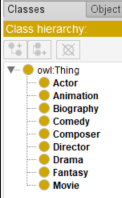


Αυτό μπορούμε να το φτιάξουμε κάνοντας απλά drag-and-drop τις αντίστοιχες κλάσεις

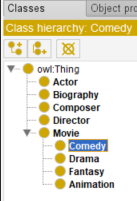

Αν επιλέξετε μια κλάση δεξιά εμφανίζεται η περιγραφή της

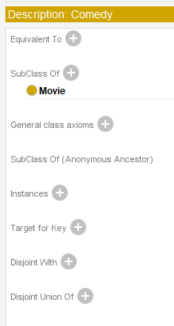

Μπορούμε να ορίσουμε ισοδυναμίες, υπερέννοιες, αξιώματα, άτομα και ξένες έννοιες πατώντας το αντίστοιχο σύμβολο protege-plus.PNG 

## 3ο Μέρος: Εμπλουτισμένη Οντολογία και Δεδομένα
Στο τρίτο (3ο) μέρος της άσκησης καλείστε να χρησιμοποιήσετε κάποιο triplestore (προτείνεται το [GraphDB](https://graphdb.ontotext.com/)) στο οποίο θα "φορτώσετε" την εμπλουτισμένη οντολογία που δημιουργήσατε μέσω του Protégé στο δεύτερο (2ο) μέρος καθώς και τα δεδομένα που κρατήσαμε από το πρώτο (1ο) μέρος, να "τρέξετε" το reasoner ο οποίος θα εφαρμόσει στα δεδομένα σας όλους τους κανόνες που έχετε ορίσει μέσω της οντολογίας σας, εμπλουτίζοντας τα δεδομένα με τύπους και ρόλους (θα δείτε αναλύτικά πως λειτουργεί ένας reasoner στο μάθημα, και θα χρησιμοποιήσουμε εκτενέστερα reasoning στο επόμενο (3ο) θέμα), και στη συνέχεια να εκτελέσετε ορισμένα SPARQL ερωτήματα στην ολοκληρωμένη οντολογία σας ώστε να δείξετε τα αποτελέσματα της ορθότητας αλλά και του εμπλουτισμού της οντολογίας σας.
Για παράδειγμα εάν έχετε δημιουργήσει έννοιες Director και Actor οι οποίες είναι υποέννοιες του Artist, μερικά SPARQL ερωτήματα που θα μπορούσατε να κάνετε είναι να δείξετε πως μπορούμε πλέον να φέρουμε όλους τους ηθοποιούς απλώς ζητώντας όλους τους individuals που έχουν type Actor, αντίστοιχα με τους σκηνοθέτες και την έννοια Director, και τέλος να δείξετε πως εάν φέρετε όλους τους καλλτέχνες (Artist) τότε έχουμε σαν απάντηση την ένωση των δύο συνόλων. Καλείστε με αυτό τον τρόπο να παρουσιάσετε τουλάχιστον 4 αντίστοιχα παραδείγματα κατά προτίμηση να μην είναι ίδιου "είδους", δηλαδή να μην είναι όλα απλώς ιεραρχίες. Παρουσιάστε και σχολιάστε στο ακόλουθο markdown τα SPARQL ερωτήματα καθώς και τα αποτελέσματά τους / τι θέλουν να δείξουν.  
Στο τέλος αυτού του μέρους να αποθηκεύσετε την οντολογία από το graphDB σε ένα αρχείο KR_Ex2_3.owl το οποίο θα παραδώσετε στο τέλος.

### Απάντηση 3

Οι παραπάνω τροποποιήσεις γίνονται export μέσω του Protege στο αρχείο ```KR_Ex2_2.owl``` το οποίο και μετατρέπουμε σε μορφή RDF/XML (αρχείο ```KR_Ex2_2.nt```) με την εκτέλεση του παρακάτω κελιού κώδικα.

In [1]:
import os
from owlready2 import *

my_world = World()
onto_protege = my_world.get_ontology("KR_Ex2_2.owl").load()

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


In [2]:
if os.path.exists("KR_Ex2_2.owl"):
    with onto_protege:
        onto_protege.save("KR_Ex2_2.nt",format="ntriples")

In [2]:
# Run reasoner
sync_reasoner(my_world)

* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /home/john/.local/lib/python3.6/site-packages/owlready2/hermit:/home/john/.local/lib/python3.6/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////tmp/tmpcz2lc05d
* Owlready2 * HermiT took 483.59704971313477 seconds
* Owlready * Reparenting props.hasDirector: {props.hasContributor, owl.ObjectProperty} => {props.hasContributor}
* Owlready * Reparenting props.hasContributedTo: {owl.ObjectProperty, props.personProperty} => {props.personProperty}
* Owlready * Reparenting props.hasWon: {owl.ObjectProperty, props.personProperty} => {props.personProperty}
* Owlready * Reparenting props.hasProduced: {owl.ObjectProperty, props.hasContributedTo} => {props.hasContributedTo}
* Owlready * Reparenting props.hasMovieNominee: {props.awardProperty, owl.ObjectProperty} => {props.awardProperty}
* Owlready * Reparenting props.hasBeenWonByMovie: {props.awardProperty, owl.ObjectProperty} => {props.awardP

## Εισαγωγή της οντολογίας στο GraphDB

<br/>

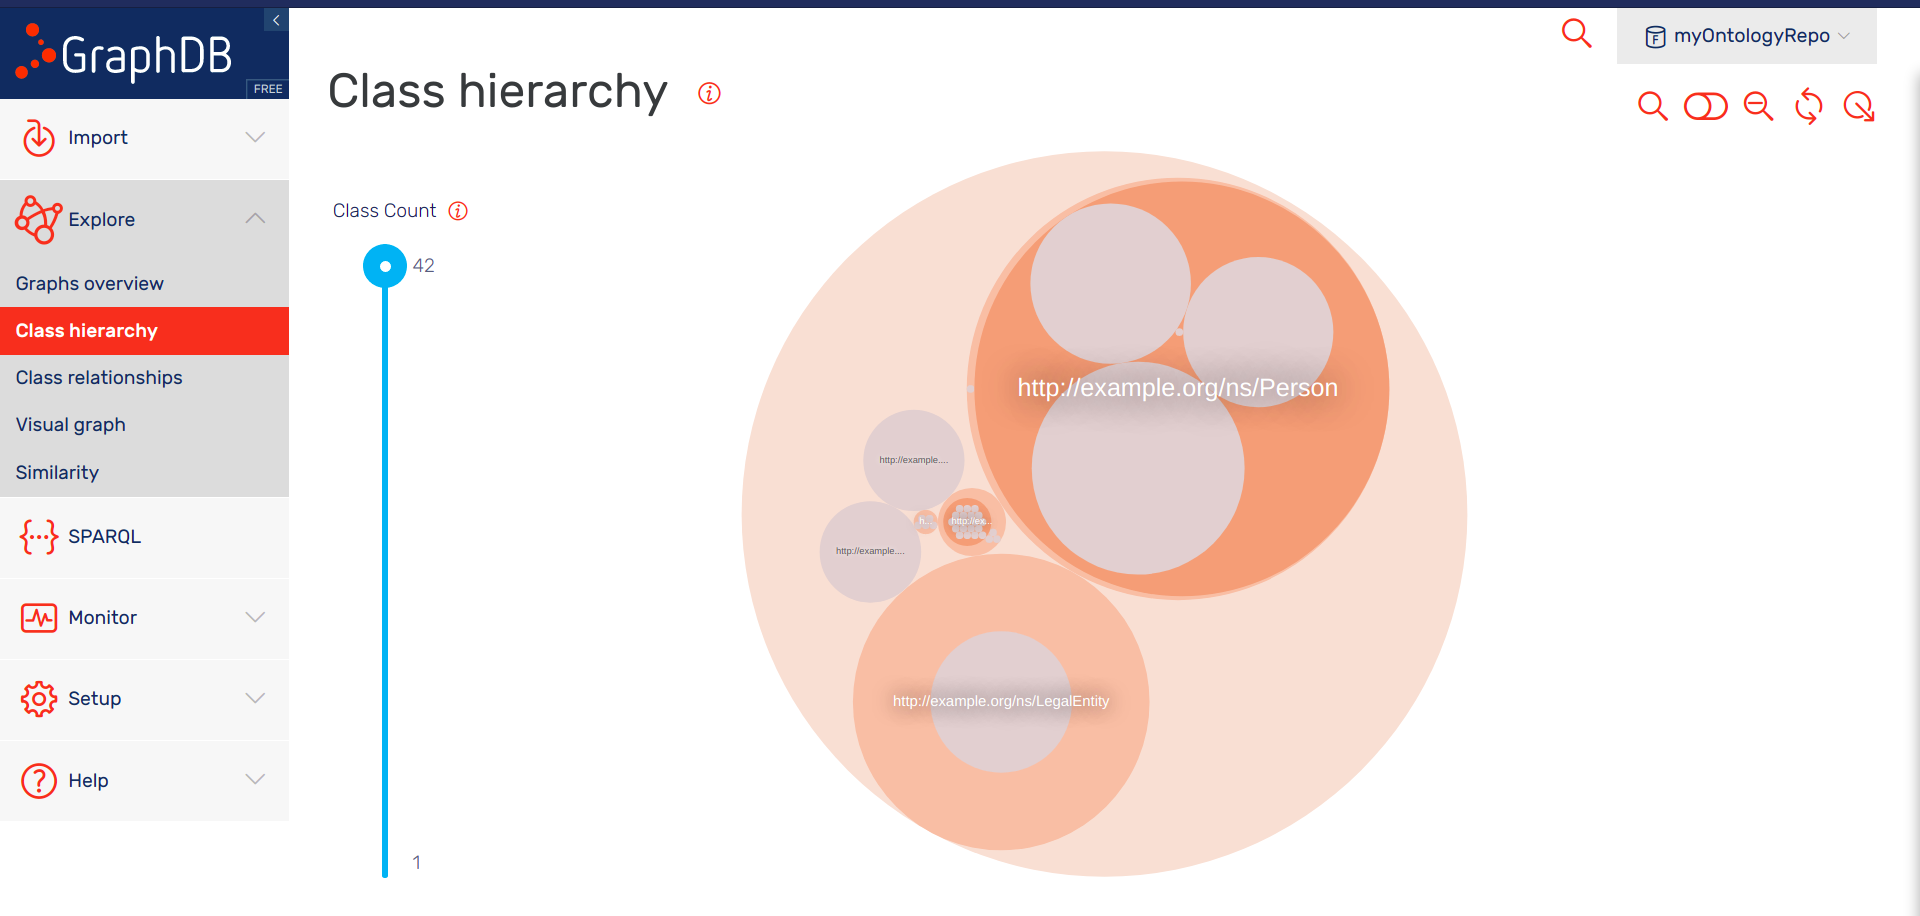

<br/>

## Υποβολή ερωτημάτων

<br/>

#### Ερώτημα 1: Εύρεση των πρώτων 10 καλλιτεχνών (ηθοποιοί, σκηνοθέτες & σεναριογράφοι), ταξινομημένων με αλφαβητική σειρά.

<br/>

Χρήση της υπερκλάσης OWL ns:Artist
```
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix props: <http://example.org/props/>
prefix ns: <http://example.org/ns/>

select ?artist
where { 
    ?artist rdf:type ns:Artist .
}
order by ?artist
limit 10
```
Παρόμοιο query χωρίς την χρήση της υπερκλάσης.
```
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix props: <http://example.org/props/>
prefix ns: <http://example.org/ns/>

select distinct ?artist
where { 
    {?artist rdf:type ns:Actor .}
    union
    {?artist rdf:type ns:Director .}
    union
    {?artist rdf:type ns:Writer .}
    union
    {?artist rdf:type ns:Cinematographer .}
}
order by ?artist
limit 10
```

<br/>
Αποτέλεσμα GraphDB

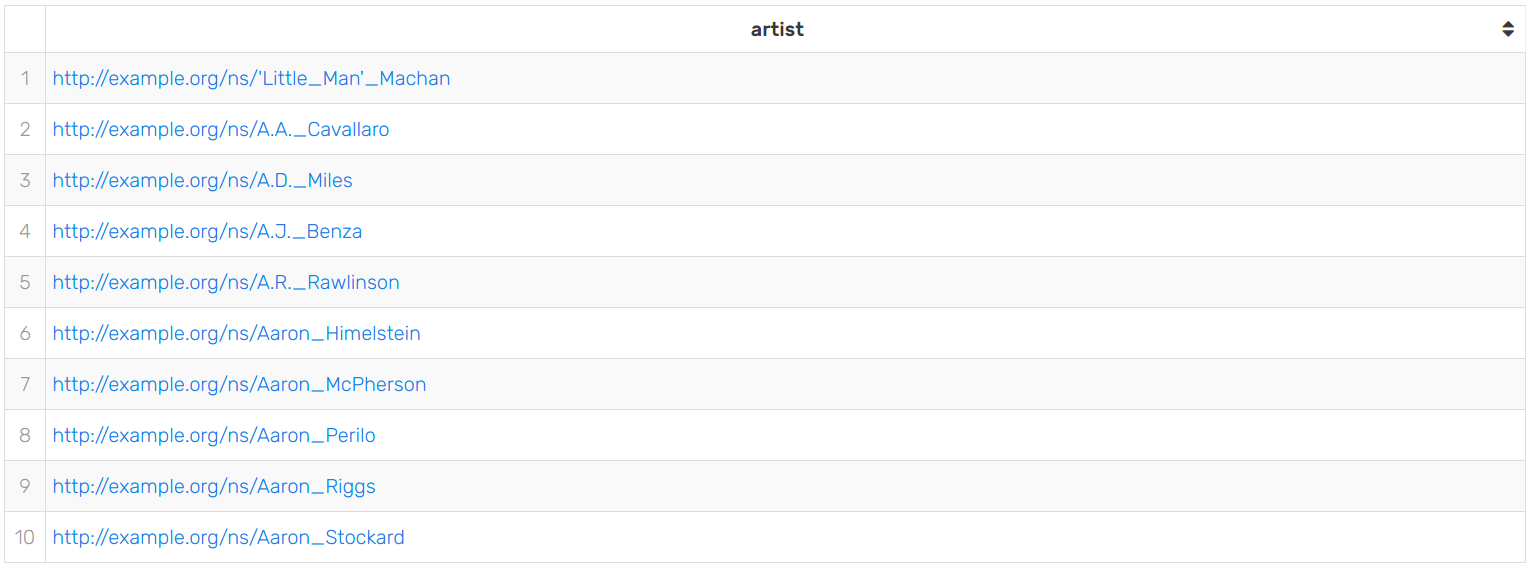

<br/>

#### Ερώτημα 2: Εύρεση όλων των συντελεστών της ταινίας *Men in Black II* μαζί με τον ρόλο του καθενός στη ταινία αυτή. Σε περίπτωση που κάποιος έχει συνδράμει στην ταινία αυτή με περισσότερους από έναν τρόπους, π.χ. ο σκηνοθέτης έχει υποδυθεί και κάποιον ρόλο, εμφανίζεται το όνομά του δύο φορές στη λίστα με την αντίστοιχη ιδιότητα.

<br/>

Χρήση του Object Property hasContributor.
```
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix props: <http://example.org/props/>
prefix ns: <http://example.org/ns/>

select distinct ?contributor ?role
where { 
    ?movie rdf:type ns:Movie ;
           props:hasTitle "Men_in_Black_II"^^xsd:string ;
           props:hasContributor ?contributor .
    ?contributor rdf:type ?role .
    {
        {
            ?role rdfs:subClassOf ns:Artist .
			filter (?role != ns:Artist) .
        }
        union
        {
            ?role rdfs:subClassOf ns:Producer .
        }
    } .
}
order by ?contributor

```
Χρήση όλων των εναλλακτικών σχέσεων
```
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix props: <http://example.org/props/>
prefix ns: <http://example.org/ns/>

select distinct ?contributor ?role
where { 
    ?movie rdf:type ns:Movie ;
           props:hasTitle "Men_in_Black_II"^^xsd:string ;
           props:hasActor|props:hasWriter|props:hasDirector|props:hasProducer|props:hasCinematographer ?contributor .
    ?contributor rdf:type ?role .
    {
        {
            ?role rdfs:subClassOf ns:Artist .
			filter (?role != ns:Artist) .
        }
        union
        {
            ?role rdfs:subClassOf ns:Producer .
        }
    } .
}
order by ?contributor
```

<br/>
Αποτελέσματα GraphDB

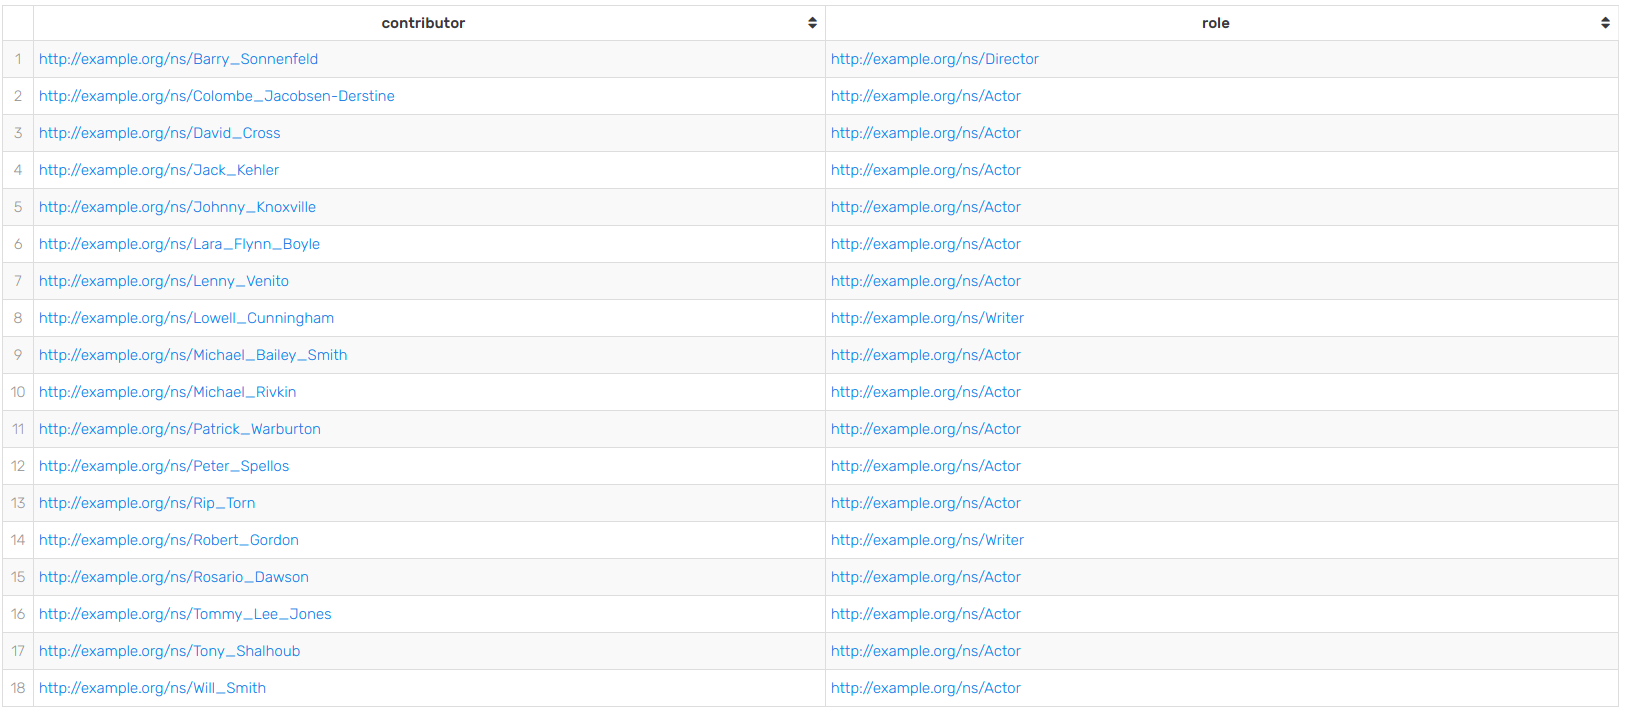

<br/>

**Σημείωση:** Τα παρακάτω ερωτήματα αξιοποιούν datatype restrictions, τα οποία δηλώθηκαν μέσω του *some* και για αυτό το λόγο εκτελέστηκαν μέσω της βιβλιοθήκης rdflib και όχι του GraphDB.

#### Ερώτημα 3: Εύρεση πρώτων δέκα ταινιών που μπορούν να χαρακτηριστούν ως μεγάλου προϋπολογισμού, δηλαδή *HighBudgetMovie* (με την σύμβαση ότι κάτι τέτοιο υφίσταται εφόσον αυτός υπερβαίνει τα 100 εκατομύρια), ταξινομημένες με βάση το προϋπολογισμό αυτό.

In [3]:
"""
    Χρήση της κλάσσης ns:HighBudgetMovie
"""

ans3 = my_world.sparql(
    """
        prefix props: <http://example.org/props/>
        prefix ns: <http://example.org/ns/>

        select distinct ?movie ?title ?budget
        where { 
            ?movie rdf:type ns:HighBudgetMovie ;
                props:hasBudget ?budget ;
                props:hasTitle ?title .
            
        }
        order by desc(?budget) ?title
        limit 10
    """
    )
for a in ans3:
    print(f"{a[0]} '{a[1].replace('_',' ')}' {a[2]}")

ns.tt0316654 'Spider-Man 2' 200000000
ns.tt0438488 'Terminator Salvation' 200000000
ns.tt0120338 'Titanic' 200000000
ns.tt0338526 'Van Helsing' 160000000
ns.tt0346491 'Alexander' 155000000
ns.tt0372784 'Batman Begins' 150000000
ns.tt0317919 'Mission: Impossible III' 150000000
ns.tt0371746 'Iron Man' 140000000
ns.tt0120912 'Men in Black II' 140000000
ns.tt0286716 'Hulk' 137000000


In [4]:
"""
    Χρήση του filter clause
"""

ans3 = my_world.sparql(
    """
        prefix props: <http://example.org/props/>
        prefix ns: <http://example.org/ns/>

        select distinct ?movie ?title ?budget
        where { 
            ?movie props:hasBudget ?budget ;
                props:hasTitle ?title .
            filter (?budget >= 100000000) .
            
        }
        order by desc(?budget) ?title
        limit 10
    """
    )
for a in ans3:
    print(f"{a[0]} '{a[1].replace('_',' ')}' {a[2]}")

ns.tt0316654 'Spider-Man 2' 200000000
ns.tt0438488 'Terminator Salvation' 200000000
ns.tt0120338 'Titanic' 200000000
ns.tt0338526 'Van Helsing' 160000000
ns.tt0346491 'Alexander' 155000000
ns.tt0372784 'Batman Begins' 150000000
ns.tt0317919 'Mission: Impossible III' 150000000
ns.tt0371746 'Iron Man' 140000000
ns.tt0120912 'Men in Black II' 140000000
ns.tt0286716 'Hulk' 137000000


#### Ερώτημα 4: Εύρεση των 5 πιο πρόσφατων ταινιών χαμηλού προϋπολογισμού (<= 2 εκατομύρια).

In [5]:
"""
    Χρήση της κλάσσης ns:LowBudgetMovie
"""

ans3 = my_world.sparql(
    """
        prefix props: <http://example.org/props/>
        prefix ns: <http://example.org/ns/>

        select distinct ?movie ?title
        where { 
            ?movie rdf:type ns:LowBudgetMovie ;
                props:hasTitle ?title ;
                props:releasedInYear ?year .           
        }
        order by desc(?year) ?title
        limit 5
    """
    )
for a in ans3:
    print(f"{a[0]} '{a[1].replace('_',' ')}'")

ns.tt2048688 '8:46'
ns.tt1190072 'The Hunter'
ns.tt1201135 'Barking Water'
ns.tt1290472 'Dragon Hunter'
ns.tt1001540 'Perestroika'


In [6]:
"""
    Χρήση του filter clause
"""

ans3 = my_world.sparql(
    """
        prefix props: <http://example.org/props/>
        prefix ns: <http://example.org/ns/>

        select distinct ?movie ?title
        where { 
            ?movie props:hasBudget ?b .
            filter (?b <= 2000000) .
            ?movie props:hasTitle ?title ;
                props:releasedInYear ?year .           
        }
        order by desc(?year) ?title
        limit 5
    """
    )
for a in ans3:
    print(f"{a[0]} '{a[1].replace('_',' ')}'")

ns.tt2048688 '8:46'
ns.tt1190072 'The Hunter'
ns.tt1201135 'Barking Water'
ns.tt1290472 'Dragon Hunter'
ns.tt1001540 'Perestroika'


### Μικρό tutorial GraphDB

Αφού εγκατασταθεί και τρέξει η free έκδοση του GraphDB, θα ανοίξει ένα παράθυρο στο browser, στη διεύθυνση http://localhost:7200/ . Φτιάχνετε ένα repository, στο ruleset επιλέγετε OWL 2 RL. Πάνω αριστερά πατάτε Import->RDF upload RDF files και ανεβάζετε δύο αρχεία:
- Το ```myonto-graphDB.owl``` που είναι η οντολογία που φτιάξατε στο protegé  
- Το ```KR-Ex2_1.owl``` που είναι ο γράφος γνώσης με διορθώσεις όπως παράχθηκε στο ερώτημα 1.2.3

Στη συνέχεια μπορείτε να πατήσετε αριστερά Explore->Class Hierarchy για να επιβεβαιώσετε πως η οντολογία φορτώθηκε σωστά, και στη συνέχεια με την επιλογή SPARQL αριστερά θα τρέξετε τα ερωτήματα για την επίλυση της άσκησης.  

## After exercise suggestions:

### Actor of the exercise: **Mads Mikkelsen**

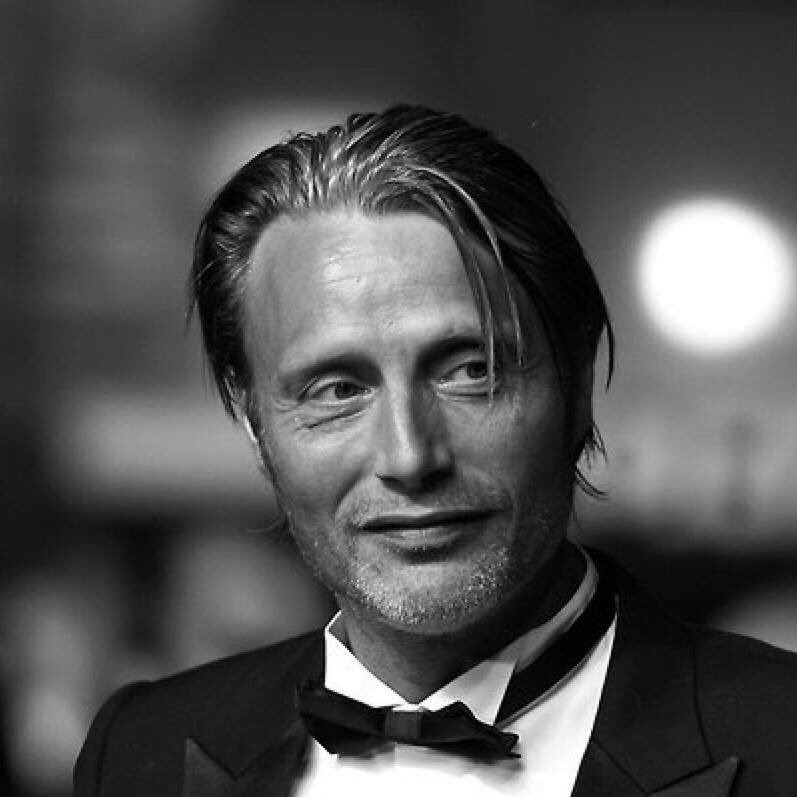

### Director of the exercise: **Gaspar Noé**


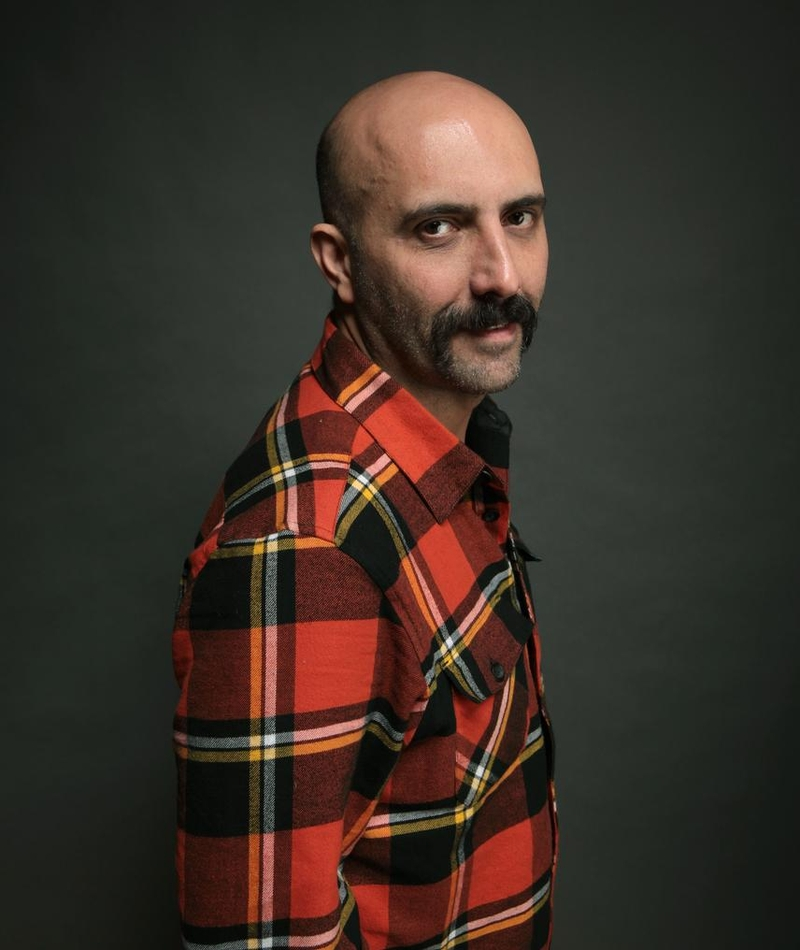

### Movie of the exercise: **The Seventh Seal**

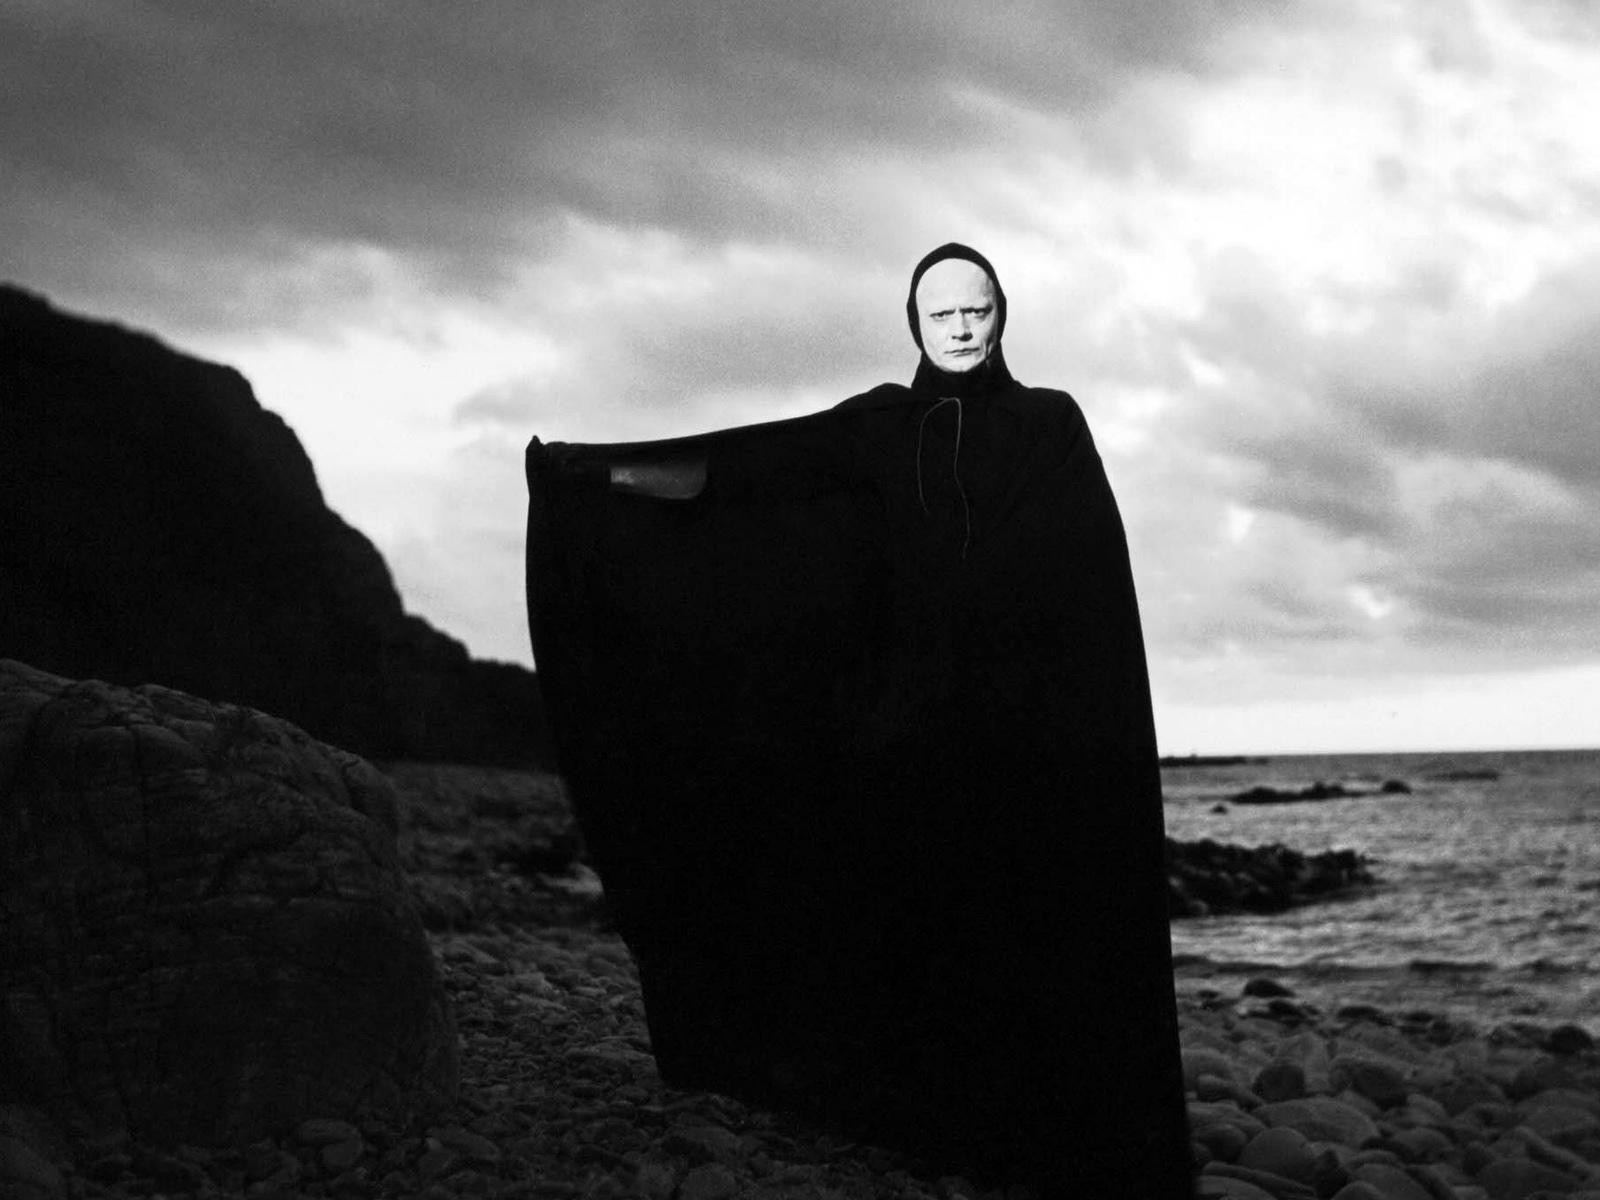

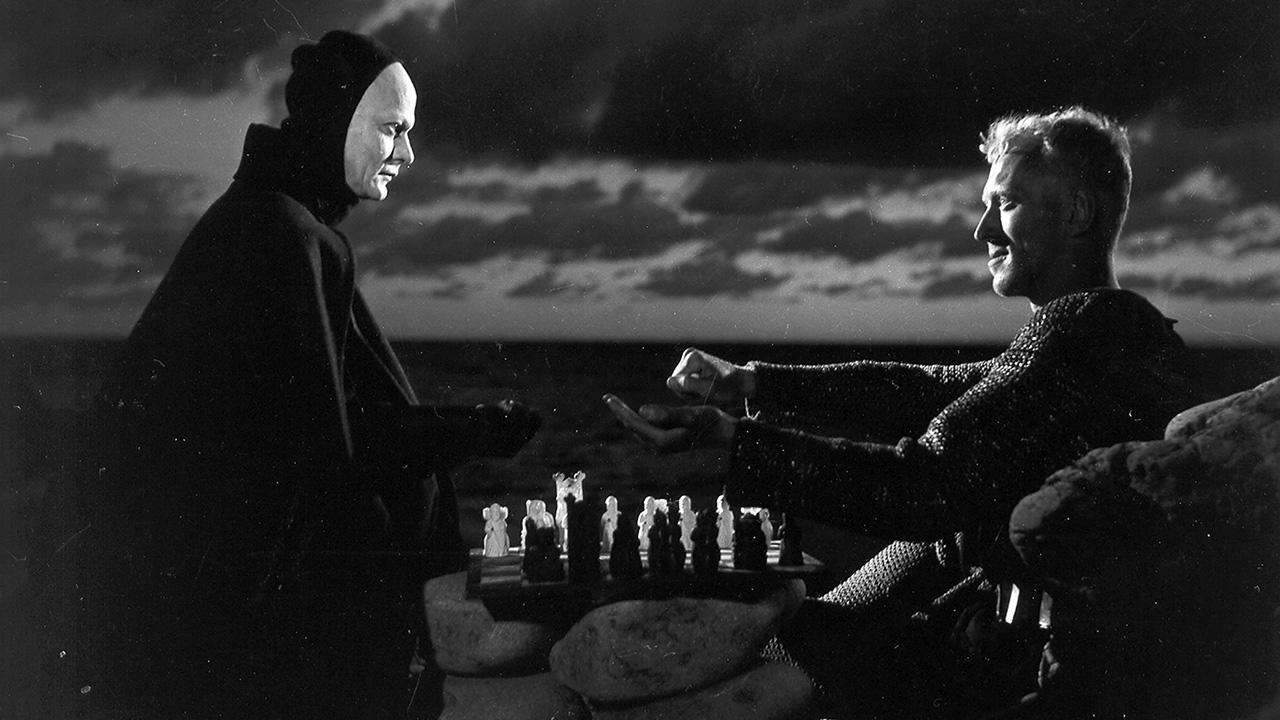

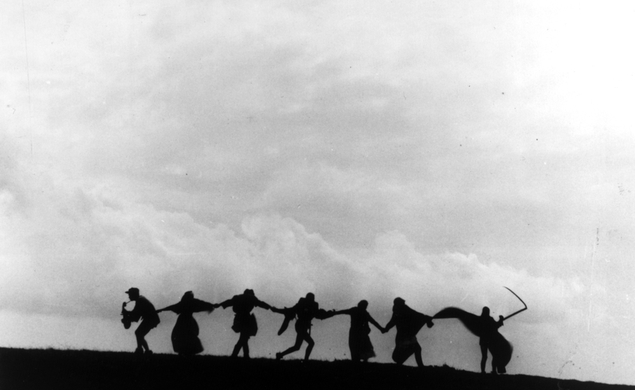

#### Any suggestions by you?

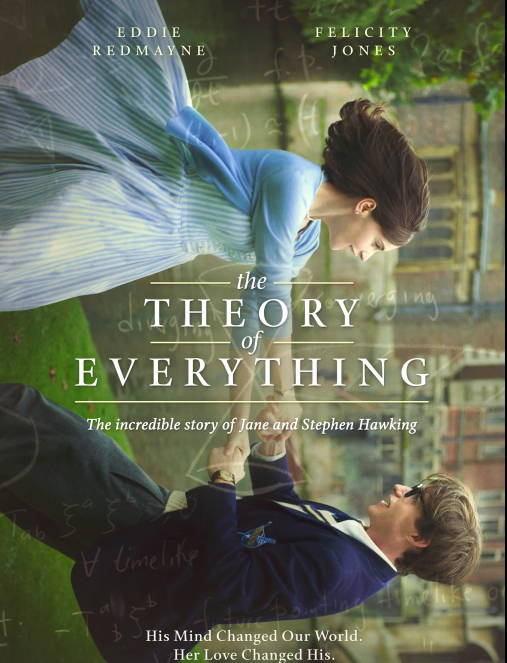